In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install unidecode

###Import libraries

In [3]:
import sys
import zipfile
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_auc_score, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from statistics import mean
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, LSTM, GRU, Embedding, Dropout, Input, SpatialDropout1D, Bidirectional
from keras.layers import Conv1D, MaxPool1D, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import Activation, LeakyReLU, Attention, Concatenate
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [132]:
plt.rcParams['figure.figsize'] = [10, 8]


In [5]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
DATASET_PATH = "/content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Data/"

###Read dataset

In [7]:
df_train = pd.read_csv(DATASET_PATH + "Lyrics-Genre-Train.csv").dropna()

df_test = pd.read_csv(DATASET_PATH + "Lyrics-Genre-Test-GroundTruth.csv")

In [8]:
df_test.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,Hip-Hop,Most folks spend their days daydreaming of fin...,8294
1,come-on-out,2012,the-elwins,Indie,Take your cold hands and put them on my face\n...,21621
2,riot,2013,bullet-for-my-valentine,Metal,Are you ready it's time for war\nWe'll break d...,3301
3,that-s-what-girls-do,2007,dream-street,Pop,You ask me why I change the color of my hair\n...,2773
4,believe-in-a-dollar,2012,cassidy,Hip-Hop,Do you believe in magic in a young girl's hear...,16797


###Training distribution

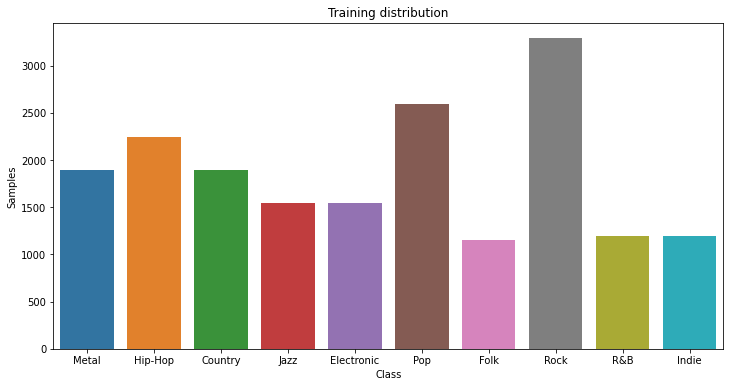

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.countplot(x='Genre', data = df_train)
plt.xlabel('Class')
plt.ylabel('Samples')
plt.title('Training distribution')
plt.show()

###Test distribution

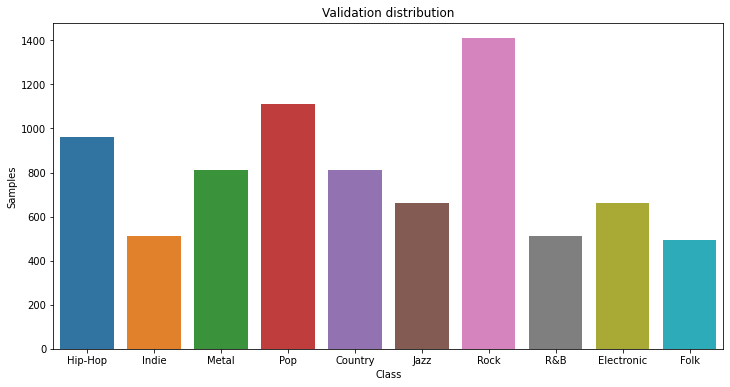

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.countplot(x='Genre', data = df_test)
plt.xlabel('Class')
plt.ylabel('Samples')
plt.title('Validation distribution')
plt.show()

###Define some constants

In [11]:
MODEL_CHECKPOINT_PATH = "/content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/"
NO_OF_CLASSES = len(list(df_train.Genre.unique()))
EPOCHS = 20
LR_RATE = 0.001
DECAY = LR_RATE/EPOCHS
BATCH_SIZE = 256
EMB_DIM = 300

In [12]:
def plot_learning_curves(history):

  fig, axs = plt.subplots(2)
  axs[0].plot(history.history["accuracy"], label = "Training")
  axs[0].plot(history.history["val_accuracy"], label = "Test")

  axs[0].set_title('Train vs Test Accuracy')
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc = 'best')

  plt.rcParams['figure.figsize'] = [12, 10]

  axs[1].set_title('Training vs Test Loss')

  axs[1].plot(history.history["loss"], label = "Training")
  axs[1].plot(history.history["val_loss"], label = "Validation")

  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Loss")
  axs[1].legend(loc = 'best')

  plt.show()

#### Create class

In [77]:
class MusicClassifier:

  def __init__(self, removeStopWords = False, stemming = False):

    self.removeStopWords = removeStopWords
    self.stemming = stemming
    self.genres = df_train.Genre.unique()
    self.genres_dict = dict(zip(self.genres, range(len(self.genres))))
    self.X_train, self.y_train = self.prep_sentences(list(df_train.Lyrics)), self.GenreToInt(df_train.Genre,self.genres_dict)
    self.X_test, self.y_test = self.prep_sentences(list(df_test.Lyrics)), self.GenreToInt(df_test.Genre,self.genres_dict)
    

  def GenreToInt(self,df, genres_dict):
    genres_labels = [genres_dict[label] for label in list(df)]

    return np.array(genres_labels).astype('int32')

  def remove_stop_words(self,X):
    ps = PorterStemmer()
    en_stopWords = set(stopwords.words('english'))
    if self.stemming:
      X_noStopWords = [' '.join([ps.stem(word) for word in (sent.lower()).split() if word not in en_stopWords]) for sent in X]
    else:
      X_noStopWords = [' '.join([word for word in (sent.lower()).split() if word not in en_stopWords]) for sent in X]

    return X_noStopWords

  def prep_sentences(self,X):
    
    X_noPunct = [song.translate(str.maketrans('','', string.punctuation)) for song in X]

    if self.removeStopWords:
      X_clean = self.remove_stop_words(X_noPunct)

    return X_clean
  
  def init_tokenizer(self):

    self.tokenizer = Tokenizer(oov_token='UNK')
    self.tokenizer.fit_on_texts(self.X_train)
    self.vocabulary = self.tokenizer.word_index

  def get_sequences(self,X):
    return self.tokenizer.texts_to_sequences(X)


  def plot_confusion_matrix(self,y_true, y_pred):
    res = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))

    df_cm = pd.DataFrame(res, index = [genre for genre in self.genres], 
                        columns = [genre for genre in self.genres])
    sns.heatmap(df_cm, annot = True, annot_kws={"size": 10}, fmt = "d")

  def make_predictions(self,model,X):
    pred = model.predict(X)

    return np.argmax(pred, axis=1)
  
  def scheduler(self,epoch, learning_rate):
    return learning_rate * 1 / (1 + DECAY * epoch)

  def get_callbacks(self,model_nr_path):

    early_stopping = EarlyStopping(min_delta=0.001,patience = 10, verbose=1, monitor='val_loss')
    model_checkpoint = ModelCheckpoint(filepath=MODEL_CHECKPOINT_PATH + model_nr_path, save_best_only=True,
                                      monitor = 'val_loss', mode = 'min', save_weights_only = False, verbose = 1)
    lr_on_plateau = ReduceLROnPlateau(patience = 5, verbose = 1, monitor='val_loss')
    csv_logger = CSVLogger(MODEL_CHECKPOINT_PATH + model_nr_path  + "/logs_model.csv")
    lr_scheduler = LearningRateScheduler(self.scheduler, verbose=1)
    callbacks_list = [early_stopping, lr_on_plateau, model_checkpoint]

    return callbacks_list
  
  def model_LSTM(self, emb_dim):
    inputs = Input(shape=(None,))

    x_embeddings = Embedding(input_dim=len(self.vocabulary) + 1, output_dim=emb_dim)(inputs)
    x_embeddings = Dropout(0.5)(x_embeddings)

    x_lstm = LSTM(units=32)(x_embeddings)
    x_lstm = Dropout(0.5)(x_lstm)
    
    x_output = Dense(NO_OF_CLASSES, activation='softmax')(x_lstm) 

    model = Model(inputs = inputs, outputs = x_output)

    return model
  
  def model_cnn(self, input_shape, emb_dim, nr_layers=2, activation='relu', dropout_rate=0.3):
    inputs = Input(shape=(None,))
    x_embeddings = Embedding(input_dim=len(self.vocabulary) + 1, output_dim=emb_dim, 
                             input_length = input_shape)(inputs)
    x_embeddings = Dropout(0.25)(x_embeddings)

    x_conv = Conv1D(32, 3, padding='same')(x_embeddings)
    x_conv = BatchNormalization()(x_conv)
    if activation == 'relu':
      x_conv = Activation('relu')(x_conv)
    else:
      x_conv = LeakyReLU(0.001)(x_conv)
    x_conv = MaxPool1D()(x_conv)
    x_conv = SpatialDropout1D(dropout_rate)(x_conv)

    for i in range(nr_layers-1):
      x_conv = Conv1D(64 * (2**i), 3, padding='same')(x_conv)
      x_conv = BatchNormalization()(x_conv)
      if activation == 'relu':
        x_conv = Activation('relu')(x_conv)
      else:
        x_conv = LeakyReLU(0.001)(x_conv)
      x_conv = MaxPool1D()(x_conv)
      x_conv = SpatialDropout1D(dropout_rate)(x_conv)

    x_flatten = GlobalAveragePooling1D()(x_conv)

    outputs = Dense(NO_OF_CLASSES, activation='softmax')(x_flatten)

    model = Model(inputs = inputs, outputs = outputs)

    return model

  def model_mlp(self, input_shape, no_dense, no_units,lr, act_func = 'relu', dropout_rate=0.2):
    inputs = Input(shape=(input_shape,))

    x_dense = Dense(no_units)(inputs)
    if act_func == 'relu':
      x_dense = Activation('relu')(x_dense)
    else:
      x_dense = LeakyReLU(0.05)(x_dense)
    x_dense = Dropout(dropout_rate)(x_dense)

    for i in range(no_dense-1):
      x_dense = Dense(no_units)(x_dense)
      if act_func == 'relu':
        x_dense = Activation('relu')(x_dense)
      else:
        x_dense = LeakyReLU(0.05)(x_dense)
      x_dense = Dropout(dropout_rate)(x_dense)

    outputs = Dense(NO_OF_CLASSES, activation='softmax')(x_dense)

    model = Model(inputs = inputs, outputs = outputs)
    model = self.compile_model(model, Adam(lr))

    return model


  def compile_model(self,model, optimizer):

    model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
    
    return model

Initialize objects

In [78]:
mc = MusicClassifier(True)
mc.init_tokenizer()

In [79]:
mc_stemming = MusicClassifier(True, True)
mc_stemming.init_tokenizer()

I have choosen three types of features to feed to various models: TF-IDF, Bag of Words and Word Embeddings. Each model was fitted with the stop words removed or each word stemmed + the stop words removed.

#TF-IDF Features

In [ ]:
tfIdfVect = TfidfVectorizer(use_idf=True)

In [ ]:
X_train_tfidf = tfIdfVect.fit_transform(mc.X_train).astype('float32')
X_test_tfidf = tfIdfVect.transform(mc.X_test).astype('float32')

In [ ]:
X_train_stem = tfIdfVect.fit_transform(mc_stemming.X_train).astype('float32')
X_test_stem = tfIdfVect.transform(mc_stemming.X_test).astype('float32')

##ANN

####No stop words

For this model I am doing grid search combined with **Stratified k-fold** - a variation of k-fold where the ratio of classes is preserved in each fold

In [ ]:
params_grid = {
  'input_shape':[X_train_tfidf.shape[1]],
  'no_dense':[1,2],
  'no_units':[32, 64],
  'lr':list(np.linspace(0.001,0.0001,5)),
  'act_func':['relu'],
  'dropout_rate':[.5, .6]
}

In [ ]:
skf = StratifiedKFold(n_splits = 5)
best_params = {}
best_val_acc = 0

In [ ]:
for i,item in enumerate(list(ParameterGrid(params_grid))):
  print("Training model #{}\n".format(i+1))
  print("\n{}".format(item))
  val_scores = []
  test_scores = []

  for j,(train_index, validate_index) in enumerate(skf.split(X_train_tfidf, mc.y_train)):
      print("\nSplit {}\n".format(j+1))
      model_mlp = mc.model_mlp(**item)

      history_mlp = model_mlp.fit(
        X_train_tfidf[train_index], mc.y_train[train_index], 
        batch_size = BATCH_SIZE,
        epochs = 15
      )
      val_acc = model_mlp.evaluate(X_train_tfidf[validate_index], mc.y_train[validate_index])[1]
      val_scores.append(val_acc)

  print("\nMean validation accuracy: {}\n".format(mean(val_scores)))

  if mean(val_scores) >= best_val_acc:
    best_params = item
    best_val_acc = mean(val_scores)



Streaming output truncated to the last 5000 lines.
Epoch 13/15
58/58 [==============================] - 0s 4ms/step - loss: 0.9500 - accuracy: 0.7066
Epoch 14/15
58/58 [==============================] - 0s 4ms/step - loss: 0.8887 - accuracy: 0.7343
Epoch 15/15
116/116 [==============================] - 0s 3ms/step - loss: 1.8704 - accuracy: 0.3984

Split 5

Epoch 1/15
58/58 [==============================] - 1s 4ms/step - loss: 2.2865 - accuracy: 0.1746
Epoch 2/15
58/58 [==============================] - 0s 4ms/step - loss: 2.1574 - accuracy: 0.2485
Epoch 3/15
58/58 [==============================] - 0s 4ms/step - loss: 1.9831 - accuracy: 0.3191
Epoch 4/15
58/58 [==============================] - 0s 4ms/step - loss: 1.8350 - accuracy: 0.3673
Epoch 5/15
58/58 [==============================] - 0s 4ms/step - loss: 1.7247 - accuracy: 0.4066
Epoch 6/15
58/58 [==============================] - 0s 4ms/step - loss: 1.6106 - accuracy: 0.4575
Epoch 7/15
58/58 [==============================] - 

In [ ]:
print("Best params:\n")
best_params

Best params:



{'act_func': 'relu',
 'dropout_rate': 0.6,
 'input_shape': 69976,
 'lr': 0.0007750000000000001,
 'no_dense': 1,
 'no_units': 64}

In [ ]:
print("Best validation accuracy: {}".format(best_val_acc))


Best validation accuracy: 0.42575438022613527


**Retraining the model with the best parameters (with higher dropout rate to avoid overfitting)**

In [ ]:
model_mlp_best = mc.model_mlp(X_train_tfidf.shape[1],1, 32,0.0007750000000000001,'relu',0.8 )

In [ ]:
callbacks_mlp_best = mc.get_callbacks('Model mlp+tfidf+gridsearch')

In [ ]:
history_mlp_best = model_mlp_best.fit(
  X_train_tfidf, mc.y_train, 
  steps_per_epoch = X_train_tfidf.shape[0] // BATCH_SIZE,
  validation_data = (X_test_tfidf, mc.y_test),
  validation_steps = X_test_tfidf.shape[0] // BATCH_SIZE,
  batch_size = BATCH_SIZE,
  callbacks = callbacks_mlp_best,
  epochs = 20
)

Epoch 1/20
72/72 [==============================] - 1s 6ms/step - loss: 2.2892 - accuracy: 0.1696 - val_loss: 2.2276 - val_accuracy: 0.2780

Epoch 00001: val_loss improved from inf to 2.22757, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model mlp+tfidf+gridsearch
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model mlp+tfidf+gridsearch/assets
Epoch 2/20
72/72 [==============================] - 0s 4ms/step - loss: 2.2065 - accuracy: 0.2424 - val_loss: 2.1329 - val_accuracy: 0.3072

Epoch 00002: val_loss improved from 2.22757 to 2.13294, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model mlp+tfidf+gridsearch
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model mlp+tfidf+gridsearch/assets
Epoch 3/20
72/72 [==============================] - 0s 4ms/step - loss: 2.

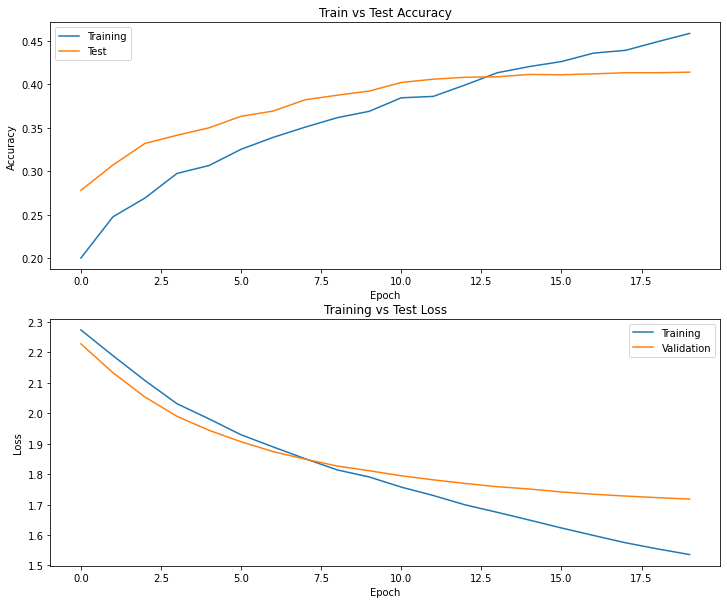

In [ ]:
plot_learning_curves(history_mlp_best)

              precision    recall  f1-score   support

           0       0.64      0.61      0.62       810
           1       0.78      0.81      0.79       960
           2       0.46      0.47      0.47       810
           3       0.60      0.23      0.33       660
           4       0.46      0.02      0.03       660
           5       0.28      0.42      0.33      1110
           6       0.72      0.17      0.27       495
           7       0.28      0.64      0.39      1410
           8       1.00      0.02      0.03       510
           9       0.00      0.00      0.00       510

    accuracy                           0.41      7935
   macro avg       0.52      0.34      0.33      7935
weighted avg       0.49      0.41      0.37      7935



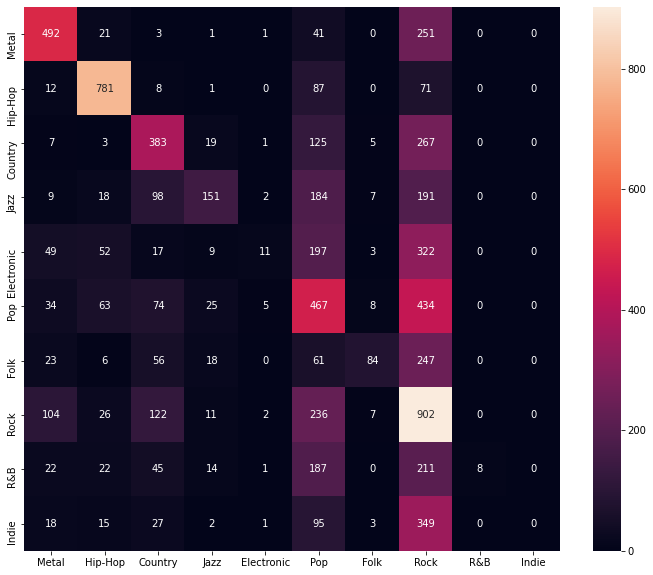

In [ ]:
predictions = np.argmax(model_mlp_best.predict(X_test_tfidf), axis = 1)
mc.plot_confusion_matrix(mc.y_test, predictions)

####No stop words + stemming

In [ ]:
model_mlp_best_stem = mc.model_mlp(X_train_stem.shape[1],1, 32,0.0007750000000000001,'relu',0.8 )

In [ ]:
callbacks_mlp_best = mc.get_callbacks('Model mlp+tfidf+gridsearch')

In [ ]:
history_mlp_best_stem = model_mlp_best_stem.fit(
  X_train_stem, mc.y_train, 
  steps_per_epoch = X_test_stem.shape[0] // BATCH_SIZE,
  validation_data = (X_test_stem, mc.y_test),
  validation_steps = X_test_stem.shape[0] // BATCH_SIZE,
  batch_size = BATCH_SIZE,
  callbacks = callbacks_mlp_best,
  epochs = 40
)

Epoch 1/40
30/30 [==============================] - 1s 16ms/step - loss: 2.2960 - accuracy: 0.1515 - val_loss: 2.2689 - val_accuracy: 0.2172

Epoch 00001: val_loss improved from inf to 2.26888, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model mlp+tfidf+gridsearch
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model mlp+tfidf+gridsearch/assets
Epoch 2/40
30/30 [==============================] - 0s 6ms/step - loss: 2.2603 - accuracy: 0.2032 - val_loss: 2.2254 - val_accuracy: 0.2473

Epoch 00002: val_loss improved from 2.26888 to 2.22537, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model mlp+tfidf+gridsearch
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model mlp+tfidf+gridsearch/assets
Epoch 3/40
30/30 [==============================] - 0s 6ms/step - loss: 2

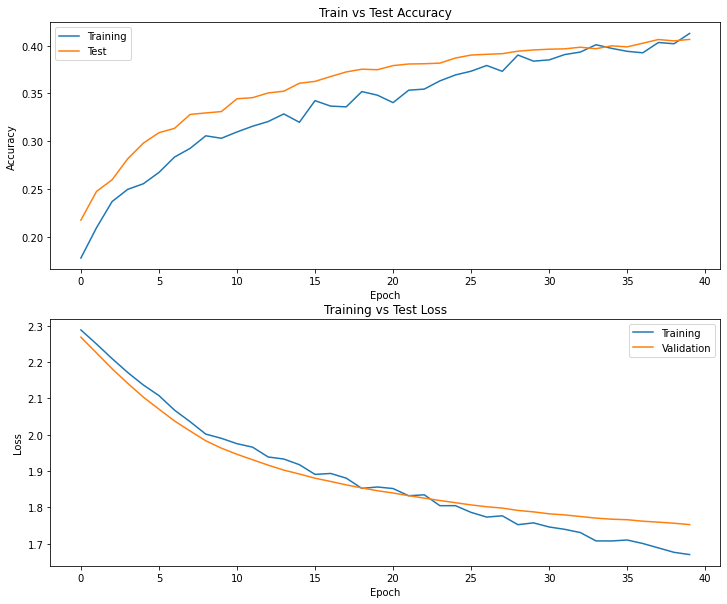

In [ ]:
plot_learning_curves(history_mlp_best_stem)

              precision    recall  f1-score   support

           0       0.63      0.64      0.63       810
           1       0.75      0.84      0.79       960
           2       0.47      0.46      0.47       810
           3       0.73      0.11      0.19       660
           4       0.44      0.01      0.01       660
           5       0.28      0.39      0.33      1110
           6       0.86      0.10      0.18       495
           7       0.27      0.68      0.39      1410
           8       0.86      0.02      0.05       510
           9       0.00      0.00      0.00       510

    accuracy                           0.41      7935
   macro avg       0.53      0.32      0.30      7935
weighted avg       0.50      0.41      0.35      7935



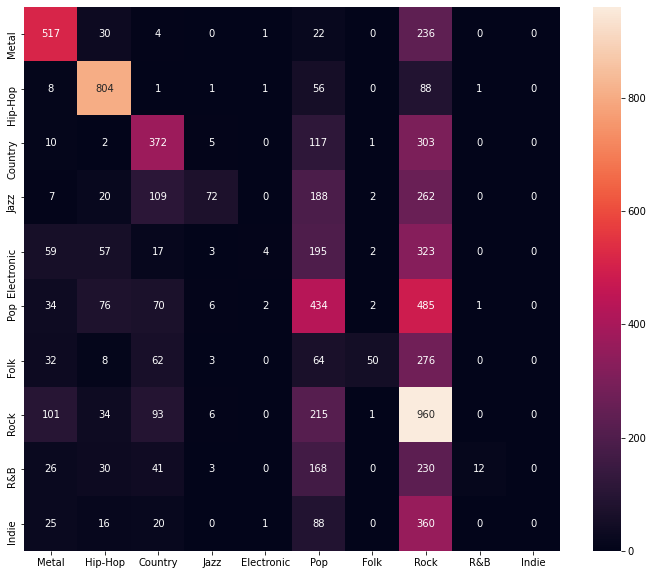

In [ ]:
predictions = np.argmax(model_mlp_best_stem.predict(X_test_stem), axis = 1)
mc.plot_confusion_matrix(mc.y_test, predictions)

##SVM + TF-IDF

####No stop words

By enabling **probability=True** SVC will internally use 5-fold cross validation

In [ ]:
svm_classifier = SVC(probability=True, kernel='rbf')

In [ ]:
svm_classifier.fit(X_train_tfidf, mc.y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
predictions_svm = svm_classifier.predict_proba(X_test_tfidf)
pred_classes_svm = np.argmax(predictions_svm, axis=1)

Test accuracy: 0.4219281663516068
              precision    recall  f1-score   support

           0       0.61      0.65      0.63       810
           1       0.75      0.80      0.77       960
           2       0.45      0.46      0.45       810
           3       0.46      0.33      0.39       660
           4       0.34      0.11      0.16       660
           5       0.31      0.34      0.32      1110
           6       0.44      0.25      0.32       495
           7       0.29      0.56      0.38      1410
           8       0.39      0.14      0.21       510
           9       0.27      0.06      0.09       510

    accuracy                           0.42      7935
   macro avg       0.43      0.37      0.37      7935
weighted avg       0.43      0.42      0.40      7935



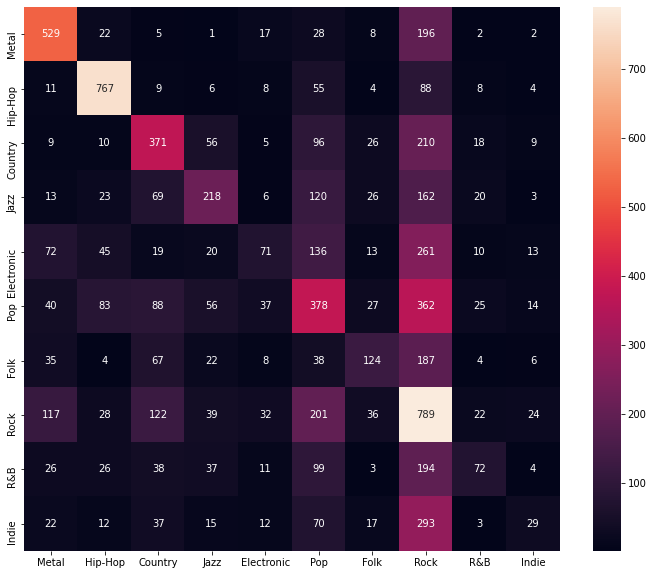

In [ ]:
print("Test accuracy: {}".format(accuracy_score(mc.y_test, pred_classes_svm)))
mc.plot_confusion_matrix(mc.y_test, pred_classes_svm)

####No stop words + stemming

In [ ]:
svm_classifier_stem = SVC(probability=True, kernel='rbf').fit(X_train_stem, mc_stemming.y_train)

In [ ]:
predictions_svm_stem = svm_classifier_stem.predict_proba(X_test_stem)

In [ ]:
pred_classes_svm = np.argmax(predictions_svm_stem, axis=1)

Test accuracy: 0.42684310018903593
              precision    recall  f1-score   support

           0       0.61      0.66      0.64       810
           1       0.76      0.80      0.78       960
           2       0.47      0.46      0.46       810
           3       0.43      0.33      0.37       660
           4       0.31      0.11      0.16       660
           5       0.32      0.35      0.33      1110
           6       0.43      0.25      0.31       495
           7       0.30      0.58      0.39      1410
           8       0.39      0.14      0.21       510
           9       0.30      0.06      0.10       510

    accuracy                           0.43      7935
   macro avg       0.43      0.37      0.38      7935
weighted avg       0.43      0.43      0.41      7935



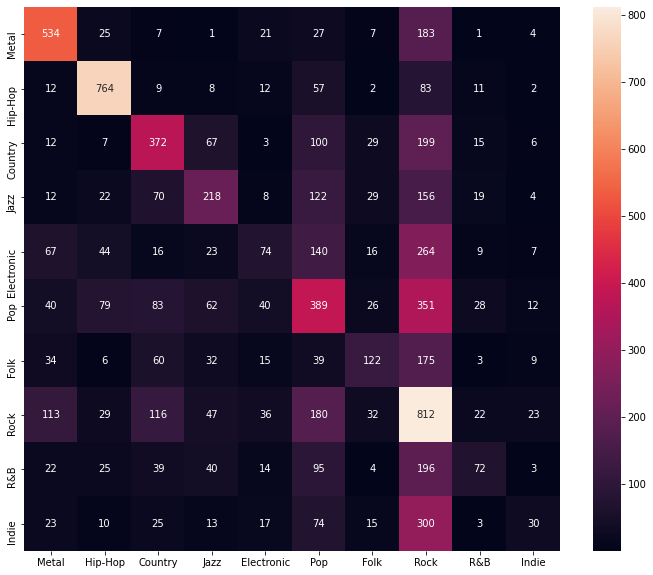

In [ ]:
print("Test accuracy: {}".format(accuracy_score(mc_stemming.y_test, pred_classes_svm)))
mc_stemming.plot_confusion_matrix(mc_stemming.y_test, pred_classes_svm)

## Naive Bayes + TF-IDF

####No stopwords

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nb_classifier = MultinomialNB()

In [ ]:
nb_classifier.fit(X_train_tfidf, mc.y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
predictions_nb = nb_classifier.predict(X_test_tfidf)

Test accuracy: 0.3030875866414619

              precision    recall  f1-score   support

           0       0.87      0.26      0.40       810
           1       0.71      0.77      0.74       960
           2       0.73      0.01      0.02       810
           3       0.00      0.00      0.00       660
           4       1.00      0.00      0.00       660
           5       0.33      0.09      0.14      1110
           6       0.95      0.04      0.07       495
           7       0.21      0.94      0.34      1410
           8       0.00      0.00      0.00       510
           9       0.00      0.00      0.00       510

    accuracy                           0.30      7935
   macro avg       0.48      0.21      0.17      7935
weighted avg       0.47      0.30      0.22      7935



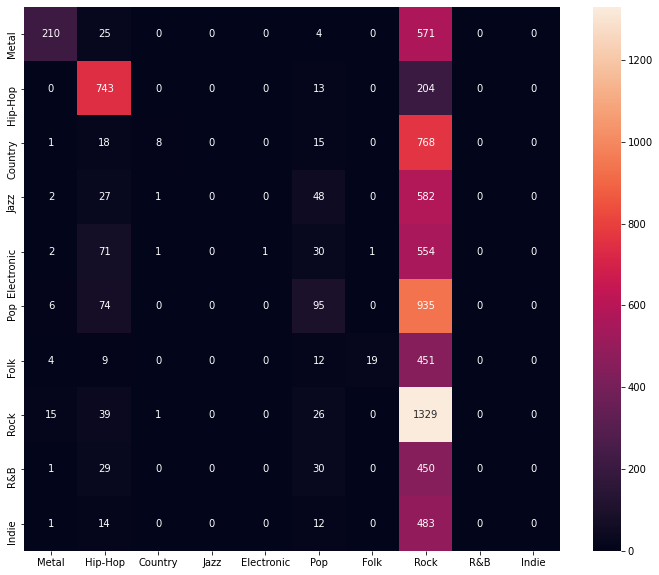

In [ ]:
print("Test accuracy: {}\n".format(accuracy_score(mc.y_test, predictions_nb)))
mc.plot_confusion_matrix(mc.y_test, predictions_nb)

####No stopwords + stemming

In [ ]:
nb_classifier.fit(X_train_stem, mc_stemming.y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
predictions_nb_stem = nb_classifier.predict(X_test_stem)

Test accuracy: 0.30674228103339635

              precision    recall  f1-score   support

           0       0.86      0.30      0.44       810
           1       0.71      0.78      0.74       960
           2       0.68      0.02      0.03       810
           3       0.00      0.00      0.00       660
           4       1.00      0.00      0.00       660
           5       0.36      0.08      0.13      1110
           6       0.90      0.04      0.07       495
           7       0.21      0.94      0.34      1410
           8       0.00      0.00      0.00       510
           9       0.00      0.00      0.00       510

    accuracy                           0.31      7935
   macro avg       0.47      0.22      0.18      7935
weighted avg       0.47      0.31      0.22      7935



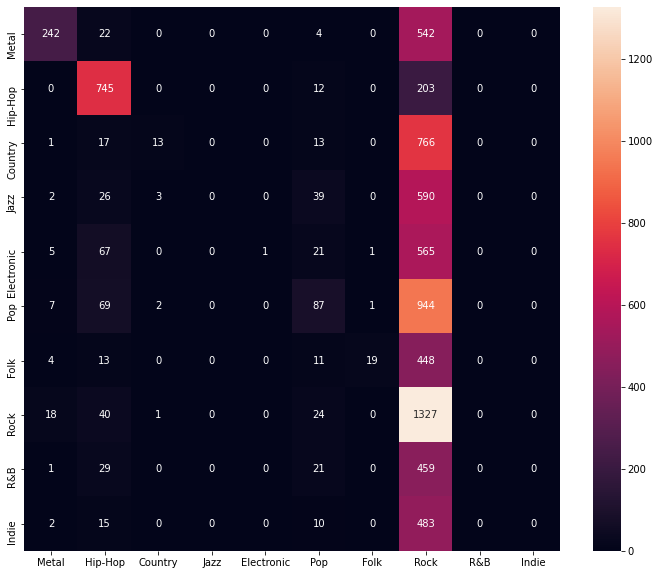

In [ ]:
print("Test accuracy: {}\n".format(accuracy_score(mc_stemming.y_test, predictions_nb_stem)))
mc_stemming.plot_confusion_matrix(mc_stemming.y_test, predictions_nb_stem)

##Logistic regression + TF-IDF

####No stop words

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr_classifier_tf = LogisticRegression(solver='sag').fit(X_train_tfidf, mc.y_train)

In [ ]:
predictions_lr = lr_classifier_tf.predict(X_test_tfidf)

Test accuracy: 0.41184625078764964

              precision    recall  f1-score   support

           0       0.59      0.66      0.62       810
           1       0.76      0.78      0.77       960
           2       0.44      0.47      0.45       810
           3       0.45      0.31      0.37       660
           4       0.30      0.10      0.15       660
           5       0.29      0.36      0.32      1110
           6       0.47      0.20      0.28       495
           7       0.28      0.54      0.37      1410
           8       0.39      0.11      0.17       510
           9       0.26      0.06      0.10       510

    accuracy                           0.41      7935
   macro avg       0.42      0.36      0.36      7935
weighted avg       0.42      0.41      0.39      7935



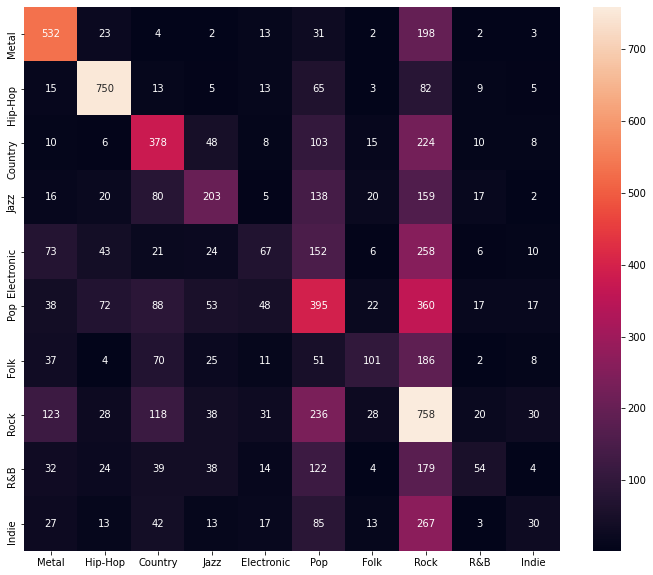

In [ ]:
print("Test accuracy: {}\n".format(accuracy_score(mc.y_test, precitions_lr)))
mc.plot_confusion_matrix(mc.y_test, predictions_lr)

####No stop words + stemming

In [ ]:
lr_classifier_tfstem = LogisticRegression(solver='sag').fit(X_train_stem, mc_stemming.y_train)

In [ ]:
predictions_lrstem = lr_classifier_tfstem.predict(X_test_stem)

Test accuracy: 0.4215500945179584

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       810
           1       0.77      0.78      0.78       960
           2       0.45      0.47      0.46       810
           3       0.43      0.32      0.37       660
           4       0.29      0.12      0.17       660
           5       0.30      0.38      0.34      1110
           6       0.45      0.21      0.29       495
           7       0.30      0.54      0.38      1410
           8       0.38      0.12      0.18       510
           9       0.26      0.06      0.10       510

    accuracy                           0.42      7935
   macro avg       0.43      0.37      0.37      7935
weighted avg       0.43      0.42      0.40      7935



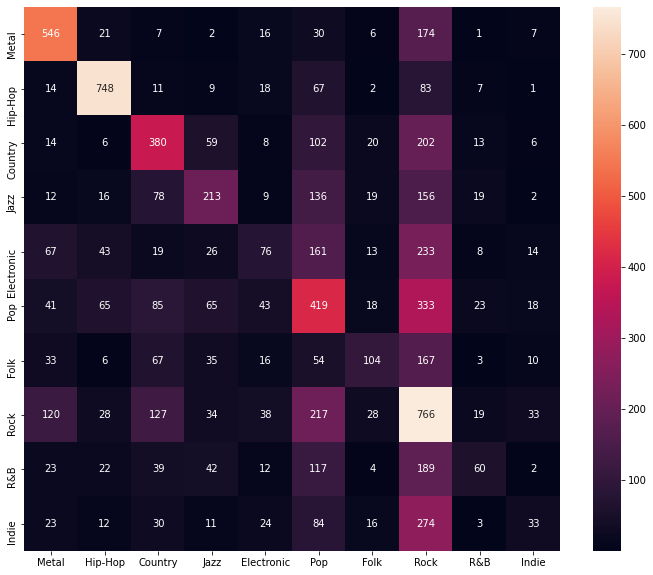

In [ ]:
print("Test accuracy: {}\n".format(accuracy_score(mc.y_test, predictions_lrstem)))
mc.plot_confusion_matrix(mc.y_test, predictions_lrstem)

##Barplot comparison

In [ ]:
import random

In [ ]:
ann_nostopWords, ann_noStemming = 0.4141, 0.4066
svm_noStopWords, svm_noStemming = 0.4219, 0.4268
nb_noStopWords, nb_noStemming = 0.3030, 0.3067
lr_noStopWords, lr_noStemming = 0.4118, 0.4215

In [ ]:
prep = ["No stop words", "No stop words + stemming"]

acc_dict = {prep[0]: [ann_nostopWords, svm_noStopWords, nb_noStopWords, lr_noStopWords], 
     prep[1]: [ann_noStemming, svm_noStemming, nb_noStemming, lr_noStemming]}
df_acc = pd.DataFrame(acc_dict)

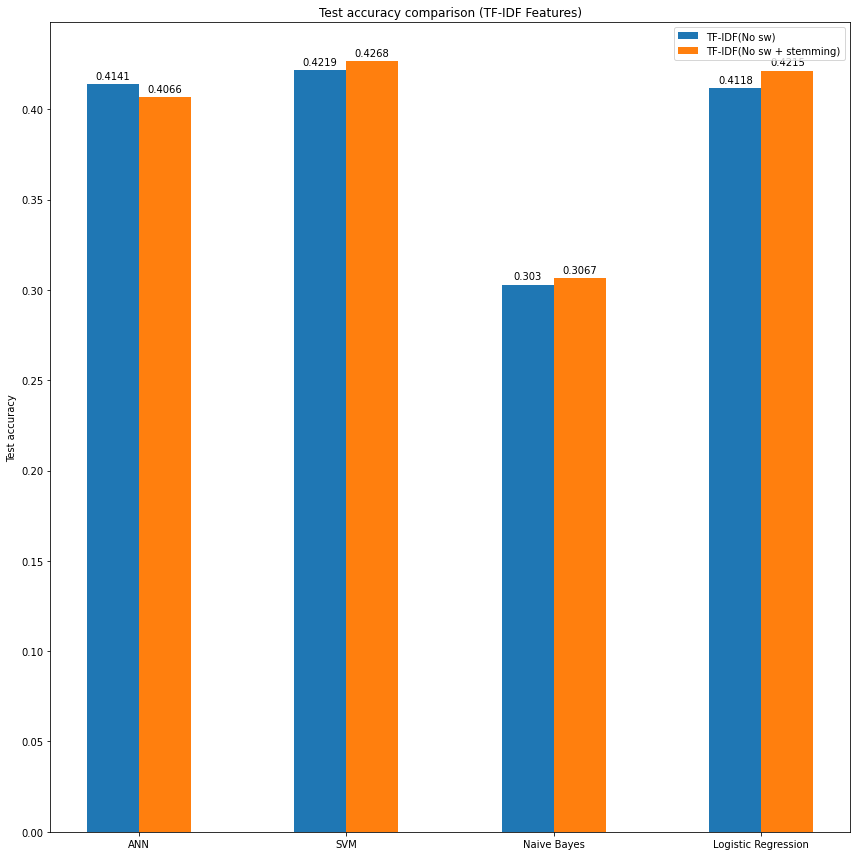

In [ ]:
labels = ['ANN', 'SVM', 'Naive Bayes', 'Logistic Regression']
sw_scores = list(df_acc["No stop words"])
sm_scores = list(df_acc["No stop words + stemming"])

x = np.arange(len(labels))
width = 0.25 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, sw_scores, width, label='TF-IDF(No sw)')
rects2 = ax.bar(x + width/2, sm_scores, width, label='TF-IDF(No sw + stemming)')

ax.set_ylabel('Test accuracy')
ax.set_title('Test accuracy comparison (TF-IDF Features)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="best")


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

We notice from the above graph that SVM combined with stemming yielded the best result on test set: **42.68**.

#BOW(Bag of words) Features

Next, we fit the above models with bag of words features.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
matr = CountVectorizer()

In [ ]:
X_trainBow_noSw = matr.fit_transform(mc.X_train).astype('int32')
X_testBow_noSw = matr.transform(mc.X_test).astype('int32')

In [ ]:
X_trainBow_stem = matr.fit_transform(mc_stemming.X_train).astype('int32')
X_testBow_stem= matr.transform(mc_stemming.X_test).astype('int32')

##ANN

####Stratified k-fold

In [ ]:
skf = StratifiedKFold(n_splits = 5)

In [ ]:
model_mlp = mc.model_mlp(X_trainBow_noSw.shape[1],2,32, 0.0007750000000000001, 'relu', 0.7)

In [ ]:
val_scores = []

####No stop words

In [ ]:
for i,(train_index, validate_index) in enumerate(skf.split(X_trainBow_noSw, mc.y_train)):
    print("\nSplit {}\n".format(i+1))

    history_mlp = model_mlp.fit(
      X_trainBow_noSw[train_index], mc.y_train[train_index], 
      batch_size = BATCH_SIZE,
      epochs = 10
    )
    val_acc = model_mlp.evaluate(X_trainBow_noSw[validate_index], mc.y_train[validate_index])[1]
    val_scores.append(val_acc)

print("\nMean validation accuracy: {}\n".format(mean(val_scores)))


Split 1

Epoch 1/10
58/58 [==============================] - 1s 3ms/step - loss: 2.2943 - accuracy: 0.1228
Epoch 2/10
58/58 [==============================] - 0s 3ms/step - loss: 2.2270 - accuracy: 0.1721
Epoch 3/10
58/58 [==============================] - 0s 3ms/step - loss: 2.1844 - accuracy: 0.2053
Epoch 4/10
58/58 [==============================] - 0s 3ms/step - loss: 2.1380 - accuracy: 0.2344
Epoch 5/10
58/58 [==============================] - 0s 3ms/step - loss: 2.1065 - accuracy: 0.2423
Epoch 6/10
58/58 [==============================] - 0s 4ms/step - loss: 2.0682 - accuracy: 0.2535
Epoch 7/10
58/58 [==============================] - 0s 3ms/step - loss: 2.0455 - accuracy: 0.2607
Epoch 8/10
58/58 [==============================] - 0s 3ms/step - loss: 2.0075 - accuracy: 0.2763
Epoch 9/10
58/58 [==============================] - 0s 3ms/step - loss: 1.9910 - accuracy: 0.2855
Epoch 10/10
116/116 [==============================] - 0s 2ms/step - loss: 1.9721 - accuracy: 0.3043

Split 

              precision    recall  f1-score   support

           0       0.74      0.47      0.57       810
           1       0.73      0.79      0.76       960
           2       0.39      0.46      0.42       810
           3       0.44      0.27      0.33       660
           4       0.33      0.02      0.04       660
           5       0.28      0.37      0.32      1110
           6       0.70      0.17      0.27       495
           7       0.27      0.63      0.37      1410
           8       0.24      0.05      0.08       510
           9       0.00      0.00      0.00       510

    accuracy                           0.39      7935
   macro avg       0.41      0.32      0.32      7935
weighted avg       0.41      0.39      0.36      7935



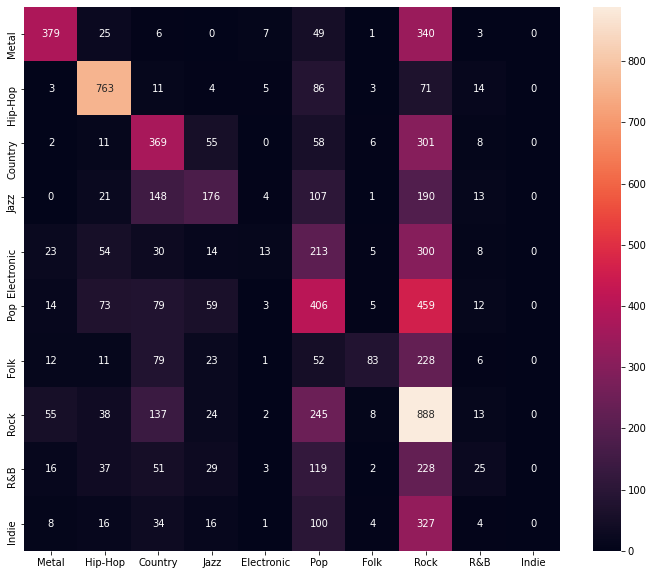

In [ ]:
predictions = np.argmax(model_mlp.predict(X_testBow_noSw), axis = 1)
mc.plot_confusion_matrix(mc.y_test, predictions)

Test accuracy:

In [ ]:
print("\nTest accuracy: {}".format(model_mlp.evaluate(X_testBow_noSw, mc.y_test)[1]))

248/248 [==============================] - 1s 2ms/step - loss: 2.1904 - accuracy: 0.3909

Test accuracy: 0.3909262716770172


####No stop words + stemming

In [ ]:
model_mlp_stem = mc.model_mlp(X_trainBow_stem.shape[1],2,32, 0.0007750000000000001, 'relu', 0.7)

In [ ]:
val_scores = []

In [ ]:
for i,(train_index, validate_index) in enumerate(skf.split(X_trainBow_stem, mc_stemming.y_train)):
    print("\nSplit {}\n".format(i+1))

    history_mlp = model_mlp_stem.fit(
      X_trainBow_stem[train_index], mc_stemming.y_train[train_index], 
      batch_size = BATCH_SIZE,
      epochs = 10
    )
    val_acc = model_mlp_stem.evaluate(X_trainBow_stem[validate_index], mc_stemming.y_train[validate_index])[1]
    val_scores.append(val_acc)

print("\nMean validation accuracy: {}\n".format(mean(val_scores)))


Split 1

Epoch 1/10
58/58 [==============================] - 1s 3ms/step - loss: 2.2891 - accuracy: 0.1378
Epoch 2/10
58/58 [==============================] - 0s 4ms/step - loss: 2.2007 - accuracy: 0.2081
Epoch 3/10
58/58 [==============================] - 0s 3ms/step - loss: 2.1468 - accuracy: 0.2394
Epoch 4/10
58/58 [==============================] - 0s 3ms/step - loss: 2.0903 - accuracy: 0.2625
Epoch 5/10
58/58 [==============================] - 0s 3ms/step - loss: 2.0575 - accuracy: 0.2833
Epoch 6/10
58/58 [==============================] - 0s 3ms/step - loss: 2.0339 - accuracy: 0.2849
Epoch 7/10
58/58 [==============================] - 0s 3ms/step - loss: 1.9890 - accuracy: 0.3077
Epoch 8/10
58/58 [==============================] - 0s 3ms/step - loss: 1.9736 - accuracy: 0.3081
Epoch 9/10
58/58 [==============================] - 0s 3ms/step - loss: 1.9389 - accuracy: 0.3136
Epoch 10/10
116/116 [==============================] - 0s 2ms/step - loss: 1.9212 - accuracy: 0.3292

Split 

              precision    recall  f1-score   support

           0       0.65      0.58      0.61       810
           1       0.75      0.78      0.77       960
           2       0.28      0.54      0.37       810
           3       0.00      0.00      0.00       660
           4       0.18      0.04      0.06       660
           5       0.28      0.42      0.33      1110
           6       0.63      0.16      0.25       495
           7       0.26      0.51      0.35      1410
           8       0.00      0.00      0.00       510
           9       0.00      0.00      0.00       510

    accuracy                           0.37      7935
   macro avg       0.30      0.30      0.27      7935
weighted avg       0.33      0.37      0.32      7935



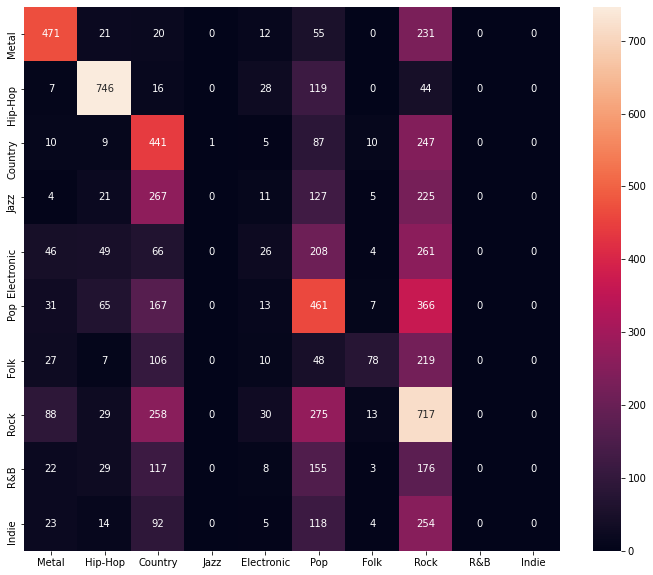

In [ ]:
predictions = np.argmax(model_mlp_stem.predict(X_testBow_stem), axis = 1)
mc.plot_confusion_matrix(mc_stemming.y_test, predictions)

Test accuracy:

In [ ]:
print("\nTest accuracy: {}".format(model_mlp_stem.evaluate(X_testBow_stem, mc_stemming.y_test)[1]))

248/248 [==============================] - 1s 2ms/step - loss: 2.2882 - accuracy: 0.3705

Test accuracy: 0.37051039934158325


##SVM

####No stop words

In [ ]:
svm_classifier_bow = SVC(probability=True, kernel='rbf').fit(X_trainBow_noSw, mc.y_train)

In [ ]:
predictions_svm = svm_classifier_bow.predict_proba(X_testBow_noSw)
pred_classes_svm = np.argmax(predictions_svm, axis=1)

Test accuracy: 0.38954001260239446
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       810
           1       0.56      0.82      0.67       960
           2       0.41      0.42      0.42       810
           3       0.43      0.26      0.32       660
           4       0.33      0.06      0.10       660
           5       0.30      0.33      0.31      1110
           6       0.46      0.18      0.26       495
           7       0.27      0.53      0.36      1410
           8       0.35      0.09      0.15       510
           9       0.17      0.01      0.02       510

    accuracy                           0.39      7935
   macro avg       0.38      0.33      0.32      7935
weighted avg       0.38      0.39      0.35      7935



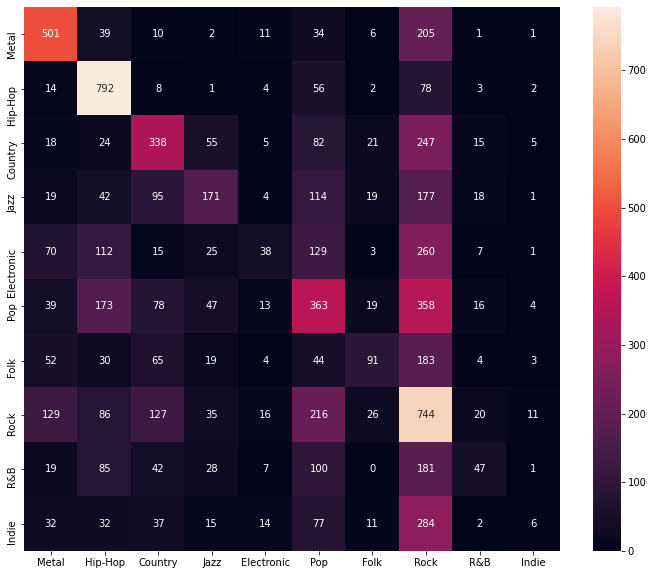

In [ ]:
print("Test accuracy: {}".format(accuracy_score(mc.y_test, pred_classes_svm)))
mc.plot_confusion_matrix(mc.y_test, pred_classes_svm)

####No stop words + stemming

In [ ]:
svm_classifier_bow = SVC(probability=True, kernel='rbf').fit(X_trainBow_stem, mc_stemming.y_train)

In [ ]:
predictions_svm = svm_classifier_bow.predict_proba(X_testBow_stem)
pred_classes_svm = np.argmax(predictions_svm, axis=1)

Test accuracy: 0.3947069943289225
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       810
           1       0.57      0.83      0.67       960
           2       0.42      0.41      0.42       810
           3       0.41      0.28      0.33       660
           4       0.32      0.05      0.09       660
           5       0.31      0.33      0.32      1110
           6       0.45      0.18      0.26       495
           7       0.28      0.55      0.37      1410
           8       0.34      0.09      0.14       510
           9       0.15      0.01      0.01       510

    accuracy                           0.39      7935
   macro avg       0.38      0.33      0.32      7935
weighted avg       0.38      0.39      0.36      7935



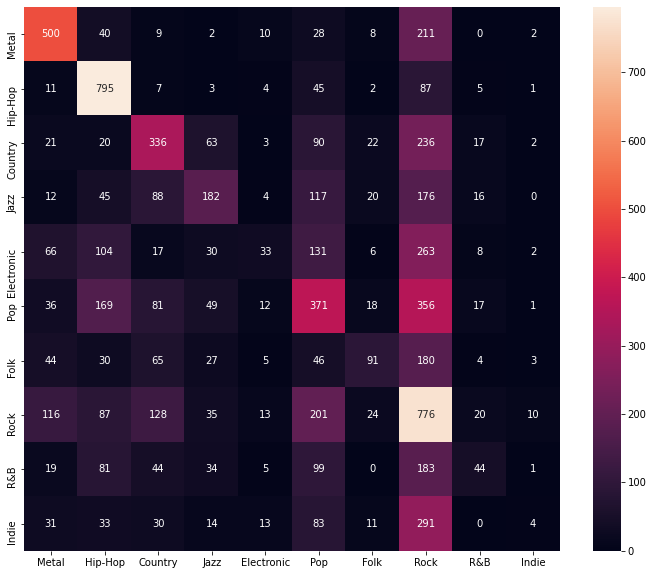

In [ ]:
print("Test accuracy: {}".format(accuracy_score(mc_stemming.y_test, pred_classes_svm)))
mc.plot_confusion_matrix(mc_stemming.y_test, pred_classes_svm)

##Naive Bayes

####No stop words

In [ ]:
nb_classifier = MultinomialNB().fit(X_trainBow_noSw, mc.y_train)

In [ ]:
predictions_nb = nb_classifier.predict(X_testBow_noSw)

Test accuracy: 0.4076874606175173

              precision    recall  f1-score   support

           0       0.62      0.61      0.62       810
           1       0.65      0.80      0.72       960
           2       0.46      0.37      0.41       810
           3       0.63      0.21      0.32       660
           4       0.32      0.05      0.08       660
           5       0.28      0.49      0.35      1110
           6       0.62      0.23      0.34       495
           7       0.29      0.58      0.39      1410
           8       0.48      0.06      0.11       510
           9       0.24      0.02      0.03       510

    accuracy                           0.41      7935
   macro avg       0.46      0.34      0.34      7935
weighted avg       0.44      0.41      0.37      7935



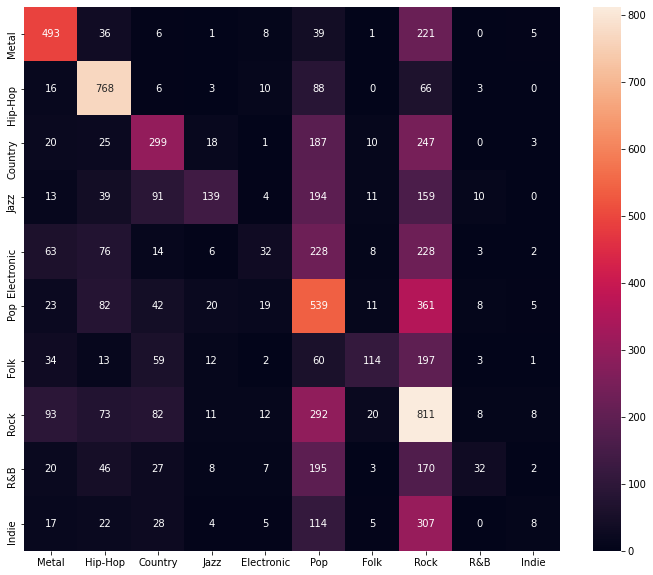

In [ ]:
print("Test accuracy: {}\n".format(accuracy_score(mc.y_test, predictions_nb)))
mc.plot_confusion_matrix(mc.y_test, predictions_nb)

####No stop words + stemming

In [ ]:
nb_classifier = MultinomialNB().fit(X_trainBow_stem, mc.y_train)

In [ ]:
predictions_nb = nb_classifier.predict(X_testBow_stem)

Test accuracy: 0.4099558916194077

              precision    recall  f1-score   support

           0       0.58      0.63      0.60       810
           1       0.67      0.80      0.73       960
           2       0.45      0.40      0.42       810
           3       0.59      0.22      0.32       660
           4       0.30      0.05      0.08       660
           5       0.29      0.47      0.36      1110
           6       0.59      0.24      0.34       495
           7       0.29      0.56      0.38      1410
           8       0.40      0.08      0.14       510
           9       0.27      0.03      0.05       510

    accuracy                           0.41      7935
   macro avg       0.44      0.35      0.34      7935
weighted avg       0.43      0.41      0.38      7935



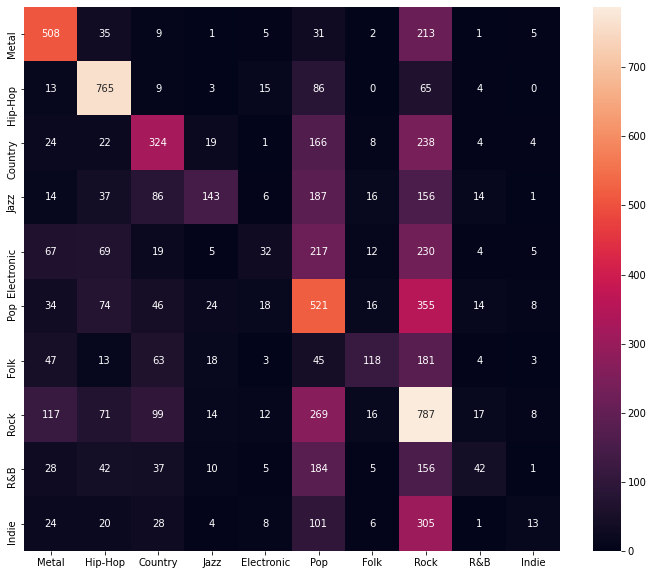

In [ ]:
print("Test accuracy: {}\n".format(accuracy_score(mc.y_test, predictions_nb)))
mc.plot_confusion_matrix(mc.y_test, predictions_nb)

##LR

####No stop words

In [ ]:
lr_classifier_bow = LogisticRegression(solver='sag').fit(X_trainBow_noSw, mc.y_train)

In [ ]:
predictions_lr = lr_classifier_bow.predict(X_testBow_noSw)

Test accuracy: 0.3935727788279773

              precision    recall  f1-score   support

           0       0.56      0.65      0.60       810
           1       0.72      0.75      0.73       960
           2       0.40      0.45      0.42       810
           3       0.37      0.31      0.34       660
           4       0.24      0.13      0.17       660
           5       0.29      0.35      0.31      1110
           6       0.39      0.25      0.30       495
           7       0.30      0.42      0.35      1410
           8       0.26      0.14      0.19       510
           9       0.18      0.10      0.13       510

    accuracy                           0.39      7935
   macro avg       0.37      0.35      0.35      7935
weighted avg       0.38      0.39      0.38      7935



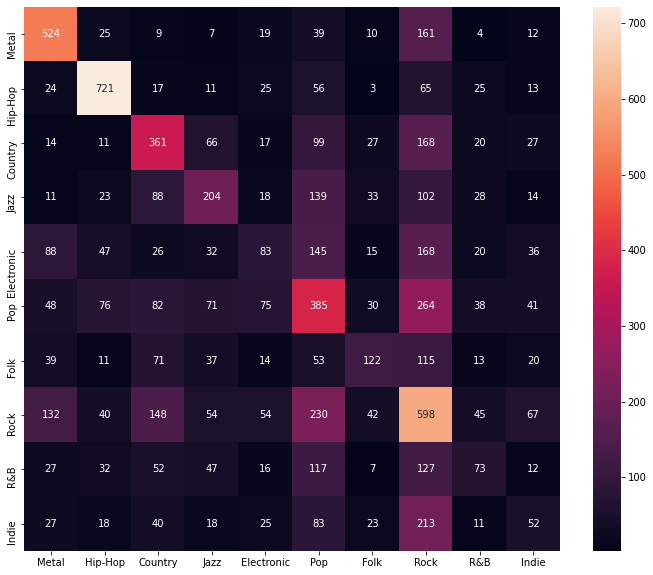

In [ ]:
print("Test accuracy: {}\n".format(accuracy_score(mc.y_test, predictions_lr)))
mc.plot_confusion_matrix(mc.y_test, predictions_lr)

####No stop words + stemming

In [ ]:
lr_classifier_bow = LogisticRegression(solver='sag').fit(X_trainBow_stem, mc.y_train)

In [ ]:
predictions_lr = lr_classifier_bow.predict(X_testBow_stem)

Test accuracy: 0.39848771266540645

              precision    recall  f1-score   support

           0       0.58      0.66      0.61       810
           1       0.72      0.75      0.74       960
           2       0.42      0.44      0.43       810
           3       0.37      0.32      0.34       660
           4       0.24      0.13      0.17       660
           5       0.29      0.36      0.32      1110
           6       0.38      0.24      0.29       495
           7       0.30      0.42      0.35      1410
           8       0.30      0.16      0.21       510
           9       0.18      0.11      0.13       510

    accuracy                           0.40      7935
   macro avg       0.38      0.36      0.36      7935
weighted avg       0.39      0.40      0.39      7935



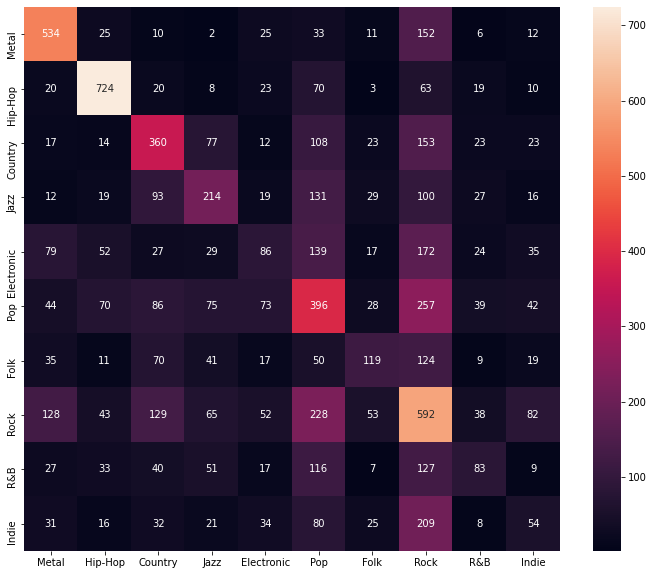

In [ ]:
print("Test accuracy: {}\n".format(accuracy_score(mc.y_test, predictions_lr)))
mc.plot_confusion_matrix(mc.y_test, predictions_lr)

##Barplot comparison

In [21]:
ann_nostopWords, ann_noStemming = 0.3909, 0.3705
svm_noStopWords, svm_noStemming = 0.3895, 0.3947
nb_noStopWords, nb_noStemming = 0.4076, 0.4099 
lr_noStopWords, lr_noStemming = 0.3935, 0.3984

In [22]:
prep = ["No stop words", "No stop words + stemming"]

acc_dict = {prep[0]: [ann_nostopWords, svm_noStopWords, nb_noStopWords, lr_noStopWords], 
     prep[1]: [ann_noStemming, svm_noStemming, nb_noStemming, lr_noStemming]}
df_acc = pd.DataFrame(acc_dict)

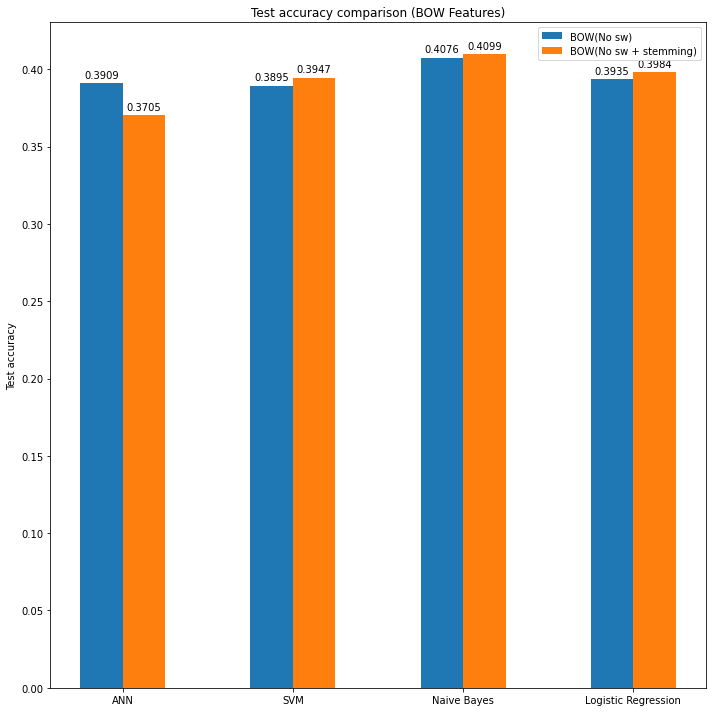

In [29]:
labels = ['ANN', 'SVM', 'Naive Bayes', 'Logistic Regression']
sw_scores = list(df_acc["No stop words"])
sm_scores = list(df_acc["No stop words + stemming"])

x = np.arange(len(labels))
width = 0.25 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, sw_scores, width, label='BOW(No sw)')
rects2 = ax.bar(x + width/2, sm_scores, width, label='BOW(No sw + stemming)')

ax.set_ylabel('Test accuracy')
ax.set_title('Test accuracy comparison (BOW Features)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="best")


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

This time Naive Bayes classifier performs the best on this kind of features.

#Word embeddings Features

In [80]:
X_train_tokenized = pad_sequences(mc.get_sequences(mc.X_train),maxlen=1000)
X_test_tokenized= pad_sequences(mc.get_sequences(mc.X_test))

In [81]:
X_train_tokenized_stem = pad_sequences(mc_stemming.get_sequences(mc_stemming.X_train),maxlen=1000)
X_test_tokenized_stem = pad_sequences(mc_stemming.get_sequences(mc_stemming.X_test))

###Model 1 - LSTM

#### No stop words

In [46]:
model_lstm = mc.model_LSTM(EMB_DIM)

In [47]:
callbacks_lstm = mc.get_callbacks('Model lstm')

In [48]:
model_lstm = mc.compile_model(model_lstm, Adam(learning_rate=0.001))

In [49]:
model_lstm.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 300)         21220200  
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 21,263,154
Trainable params: 21,263,154
Non-trainable params: 0
_______________________________________________

In [50]:
history_lstm = model_lstm.fit(
  X_train_tokenized, mc.y_train, 
  batch_size = BATCH_SIZE,
  epochs = 8,
  validation_split = 0.2,
  callbacks = callbacks_lstm
)



Epoch 1/8
58/58 [==============================] - 26s 416ms/step - loss: 2.2839 - accuracy: 0.1499 - val_loss: 2.1800 - val_accuracy: 0.2403

Epoch 00001: val_loss improved from inf to 2.18005, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model lstm/assets


Epoch 2/8
58/58 [==============================] - 25s 423ms/step - loss: 2.0878 - accuracy: 0.2814 - val_loss: 1.9793 - val_accuracy: 0.3203

Epoch 00002: val_loss improved from 2.18005 to 1.97933, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model lstm/assets


Epoch 3/8
58/58 [==============================] - 25s 425ms/step - loss: 1.8446 - accuracy: 0.3616 - val_loss: 1.9407 - val_accuracy: 0.3322

Epoch 00003: val_loss improved from 1.97933 to 1.94073, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model lstm/assets


Epoch 4/8
58/58 [==============================] - 25s 424ms/step - loss: 1.6464 - accuracy: 0.4347 - val_loss: 1.9332 - val_accuracy: 0.3435

Epoch 00004: val_loss improved from 1.94073 to 1.93317, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model lstm/assets


Epoch 5/8
58/58 [==============================] - 24s 422ms/step - loss: 1.4444 - accuracy: 0.5075 - val_loss: 1.9863 - val_accuracy: 0.3513

Epoch 00005: val_loss did not improve from 1.93317
Epoch 6/8
58/58 [==============================] - 25s 425ms/step - loss: 1.2713 - accuracy: 0.5759 - val_loss: 2.0441 - val_accuracy: 0.3503

Epoch 00006: val_loss did not improve from 1.93317
Epoch 7/8
58/58 [==============================] - 24s 411ms/step - loss: 1.1268 - accuracy: 0.6497 - val_loss: 2.1501 - val_accuracy: 0.3500

Epoch 00007: val_loss did not improve from 1.93317
Epoch 8/8
58/58 [==============================] - 24s 413ms/step - loss: 1.0063 - accuracy: 0.6902 - val_loss: 2.1527 - val_accuracy: 0.3395

Epoch 00008: val_loss did not improve from 1.93317


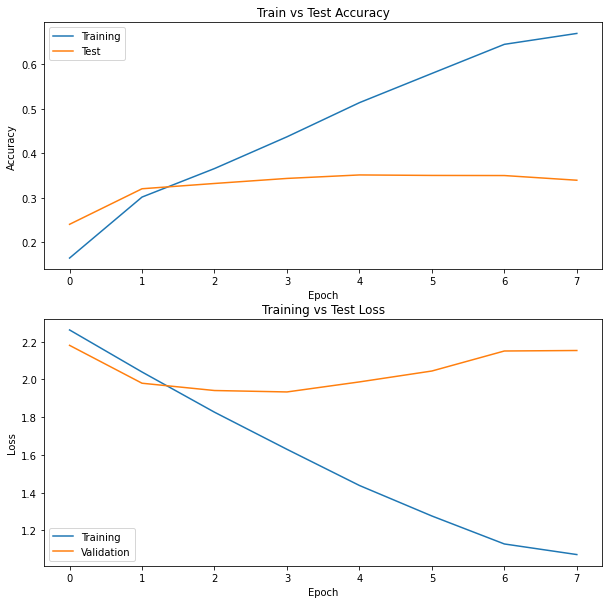

In [51]:
plot_learning_curves(history_lstm)

              precision    recall  f1-score   support

           0       0.53      0.57      0.55       810
           1       0.71      0.72      0.71       960
           2       0.31      0.44      0.36       810
           3       0.26      0.19      0.22       660
           4       0.15      0.12      0.13       660
           5       0.27      0.25      0.26      1110
           6       0.19      0.18      0.18       495
           7       0.28      0.34      0.31      1410
           8       0.21      0.08      0.11       510
           9       0.12      0.12      0.12       510

    accuracy                           0.34      7935
   macro avg       0.30      0.30      0.30      7935
weighted avg       0.33      0.34      0.33      7935



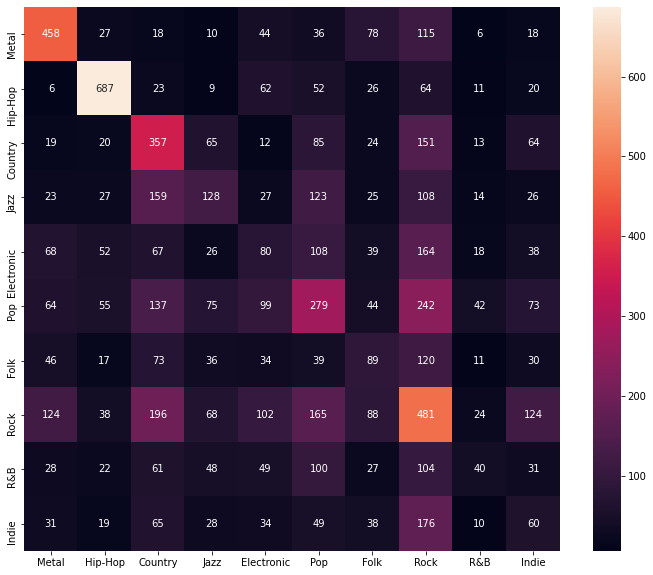

In [52]:
predictions = np.argmax(model_lstm.predict(X_test_tokenized), axis = 1)
mc.plot_confusion_matrix(mc.y_test, predictions)

In [53]:
print("\nTest accuracy: {}".format(model_lstm.evaluate(X_test_tokenized, mc.y_test)[1]))

248/248 [==============================] - 8s 29ms/step - loss: 2.2061 - accuracy: 0.3351

Test accuracy: 0.33509767055511475


#### No stop words + stemming

In [68]:
model_lstm_stem = mc_stemming.model_LSTM(EMB_DIM)

In [69]:
callbacks_lstm_stem = mc_stemming.get_callbacks('Model lstm')

In [70]:
model_lstm_stem = mc_stemming.compile_model(model_lstm_stem, Adam(learning_rate=0.001))

In [71]:
model_lstm_stem.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_8 (Embedding)      (None, None, 300)         15860400  
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 15,903,354
Trainable params: 15,903,354
Non-trainable params: 0
_______________________________________________

In [72]:
history_lstm_stem = model_lstm_stem.fit(
  X_train_tokenized_stem, mc.y_train, 
  batch_size = BATCH_SIZE,
  epochs = 8,
  validation_split = 0.2
  )

Epoch 1/8
58/58 [==============================] - 23s 363ms/step - loss: 2.2759 - accuracy: 0.1404 - val_loss: 2.0924 - val_accuracy: 0.2792
Epoch 2/8
58/58 [==============================] - 21s 364ms/step - loss: 2.0613 - accuracy: 0.2817 - val_loss: 1.9782 - val_accuracy: 0.3087
Epoch 3/8
58/58 [==============================] - 21s 366ms/step - loss: 1.8905 - accuracy: 0.3510 - val_loss: 1.9251 - val_accuracy: 0.3243
Epoch 4/8
58/58 [==============================] - 21s 362ms/step - loss: 1.7637 - accuracy: 0.3946 - val_loss: 1.9508 - val_accuracy: 0.3295
Epoch 5/8
58/58 [==============================] - 21s 366ms/step - loss: 1.6461 - accuracy: 0.4510 - val_loss: 1.8876 - val_accuracy: 0.3513
Epoch 6/8
58/58 [==============================] - 21s 364ms/step - loss: 1.5089 - accuracy: 0.4981 - val_loss: 1.9274 - val_accuracy: 0.3613
Epoch 7/8
58/58 [==============================] - 21s 363ms/step - loss: 1.3747 - accuracy: 0.5488 - val_loss: 1.9589 - val_accuracy: 0.3484
Epoch 

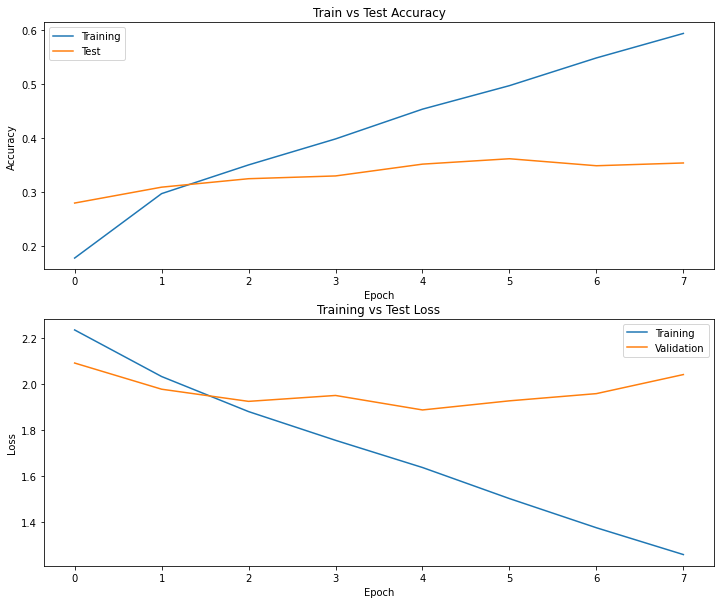

In [73]:
plot_learning_curves(history_lstm_stem)

              precision    recall  f1-score   support

           0       0.52      0.61      0.56       810
           1       0.74      0.76      0.75       960
           2       0.34      0.37      0.36       810
           3       0.27      0.24      0.25       660
           4       0.15      0.09      0.11       660
           5       0.26      0.24      0.25      1110
           6       0.18      0.21      0.19       495
           7       0.27      0.41      0.33      1410
           8       0.38      0.03      0.05       510
           9       0.14      0.11      0.12       510

    accuracy                           0.35      7935
   macro avg       0.33      0.31      0.30      7935
weighted avg       0.34      0.35      0.33      7935



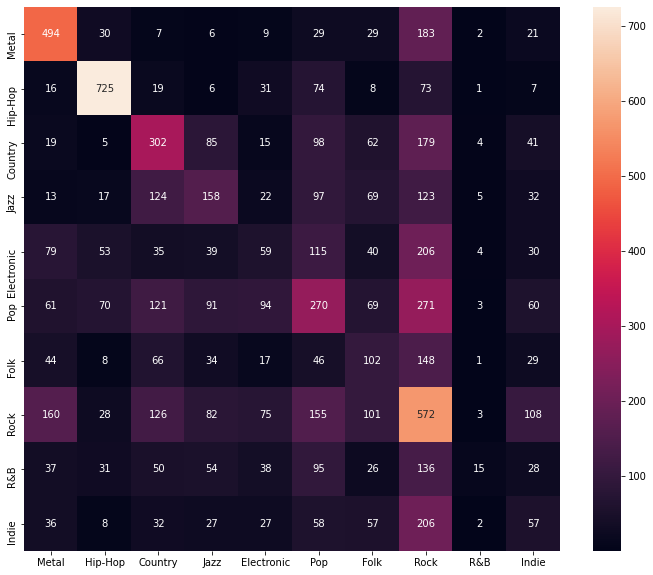

In [74]:
predictions = np.argmax(model_lstm_stem.predict(X_test_tokenized_stem), axis = 1)
mc.plot_confusion_matrix(mc.y_test, predictions)

In [76]:
print("\nTest accuracy: {}".format(model_lstm_stem.evaluate(X_test_tokenized_stem, mc.y_test)[1]))

248/248 [==============================] - 8s 29ms/step - loss: 2.0802 - accuracy: 0.3471

Test accuracy: 0.34706994891166687


From the above graph (the learning curves) we can see that our models are overfitting on the training data, indicating that this model might not be the right choice for this particular task. Next, we try a CNN based model.

###Model 2 - CNN

####No stop words

In [118]:
model_cnn = mc.model_cnn(X_train_tokenized.shape[1], EMB_DIM, 2, 'relu', 0.5)

In [119]:
model_cnn = mc.compile_model(model_cnn, Adam(learning_rate=0.001))

In [120]:
callbacks_cnn = mc.get_callbacks('Model cnn1')

In [121]:
model_cnn.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_14 (Embedding)     (None, None, 300)         21220200  
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          28832     
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 32)          128       
_________________________________________________________________
activation_8 (Activation)    (None, None, 32)          0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 32)          0  

In [122]:
history_cnn = model_cnn.fit(
  X_train_tokenized, mc.y_train, 
  batch_size = BATCH_SIZE,
  epochs = 15,
  validation_split = 0.2,
  callbacks = callbacks_cnn
  )

Epoch 1/15
58/58 [==============================] - 25s 417ms/step - loss: 2.4699 - accuracy: 0.1391 - val_loss: 2.2594 - val_accuracy: 0.1928

Epoch 00001: val_loss improved from inf to 2.25941, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


Epoch 2/15
58/58 [==============================] - 24s 410ms/step - loss: 2.1397 - accuracy: 0.2371 - val_loss: 2.2201 - val_accuracy: 0.2285

Epoch 00002: val_loss improved from 2.25941 to 2.22007, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


Epoch 3/15
58/58 [==============================] - 24s 408ms/step - loss: 2.0428 - accuracy: 0.2692 - val_loss: 2.2004 - val_accuracy: 0.2179

Epoch 00003: val_loss improved from 2.22007 to 2.20042, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


Epoch 4/15
58/58 [==============================] - 24s 409ms/step - loss: 1.9922 - accuracy: 0.2893 - val_loss: 2.1830 - val_accuracy: 0.2298

Epoch 00004: val_loss improved from 2.20042 to 2.18298, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


Epoch 5/15
58/58 [==============================] - 24s 410ms/step - loss: 1.9013 - accuracy: 0.3304 - val_loss: 2.1533 - val_accuracy: 0.2617

Epoch 00005: val_loss improved from 2.18298 to 2.15329, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


Epoch 6/15
58/58 [==============================] - 24s 407ms/step - loss: 1.8019 - accuracy: 0.3729 - val_loss: 2.1139 - val_accuracy: 0.2495

Epoch 00006: val_loss improved from 2.15329 to 2.11390, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


Epoch 7/15
58/58 [==============================] - 24s 414ms/step - loss: 1.7203 - accuracy: 0.4126 - val_loss: 2.0537 - val_accuracy: 0.2744

Epoch 00007: val_loss improved from 2.11390 to 2.05371, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


Epoch 8/15
58/58 [==============================] - 24s 411ms/step - loss: 1.5980 - accuracy: 0.4644 - val_loss: 2.0029 - val_accuracy: 0.2927

Epoch 00008: val_loss improved from 2.05371 to 2.00295, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


Epoch 9/15
58/58 [==============================] - 24s 408ms/step - loss: 1.5042 - accuracy: 0.4953 - val_loss: 1.9555 - val_accuracy: 0.3108

Epoch 00009: val_loss improved from 2.00295 to 1.95554, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn1/assets


Epoch 10/15
58/58 [==============================] - 24s 407ms/step - loss: 1.4097 - accuracy: 0.5396 - val_loss: 1.9913 - val_accuracy: 0.2854

Epoch 00010: val_loss did not improve from 1.95554
Epoch 11/15
58/58 [==============================] - 23s 400ms/step - loss: 1.3126 - accuracy: 0.5721 - val_loss: 2.2771 - val_accuracy: 0.2776

Epoch 00011: val_loss did not improve from 1.95554
Epoch 12/15
58/58 [==============================] - 23s 401ms/step - loss: 1.2231 - accuracy: 0.6115 - val_loss: 2.0866 - val_accuracy: 0.3062

Epoch 00012: val_loss did not improve from 1.95554
Epoch 13/15
58/58 [==============================] - 23s 400ms/step - loss: 1.1482 - accuracy: 0.6295 - val_loss: 4.2271 - val_accuracy: 0.2290

Epoch 00013: val_loss did not improve from 1.95554
Epoch 14/15
58/58 [==============================] - 23s 399ms/step - loss: 1.0718 - accuracy: 0.6614 - val_loss: 6.8968 - val_accuracy: 0.2214

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.000100000004

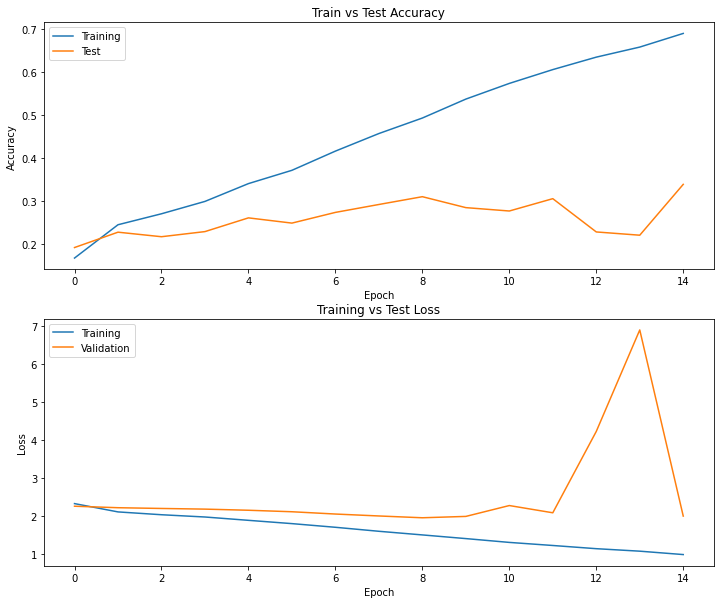

In [123]:
plot_learning_curves(history_cnn)

              precision    recall  f1-score   support

           0       0.59      0.29      0.39       810
           1       0.91      0.48      0.63       960
           2       0.37      0.17      0.23       810
           3       0.37      0.01      0.02       660
           4       0.50      0.01      0.01       660
           5       0.29      0.08      0.12      1110
           6       0.83      0.09      0.16       495
           7       0.21      0.93      0.34      1410
           8       0.00      0.00      0.00       510
           9       0.00      0.00      0.00       510

    accuracy                           0.29      7935
   macro avg       0.41      0.21      0.19      7935
weighted avg       0.41      0.29      0.23      7935



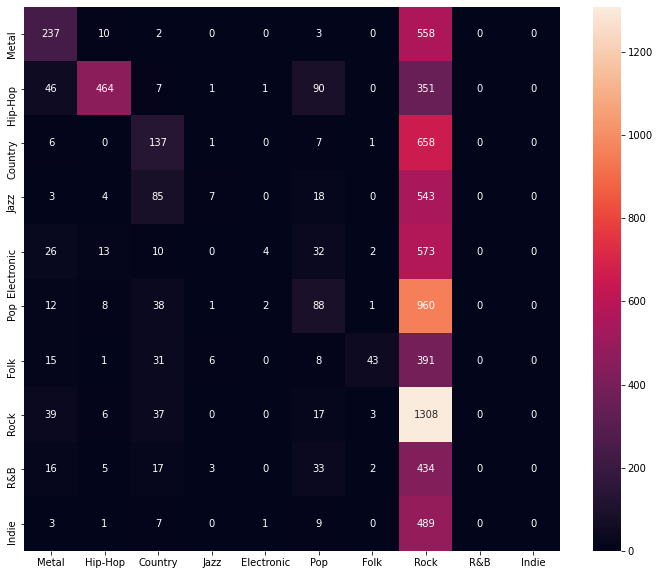

In [124]:
model_cnn = load_model(MODEL_CHECKPOINT_PATH + 'Model cnn1')
predictions = np.argmax(model_cnn.predict(X_test_tokenized), axis = 1)
mc.plot_confusion_matrix(mc.y_test, predictions)

In [125]:
print("\nTest accuracy: {}".format(model_cnn.evaluate(X_test_tokenized, mc.y_test)[1]))

248/248 [==============================] - 4s 14ms/step - loss: 2.0120 - accuracy: 0.2883

Test accuracy: 0.28834277391433716


####No stop words + stemming

In [107]:
model_cnn_stem = mc_stemming.model_cnn(X_train_tokenized_stem.shape[1], EMB_DIM, 2, 'relu', 0.5)

In [108]:
model_cnn_stem = mc_stemming.compile_model(model_cnn_stem, Adam(learning_rate=0.001))

In [109]:
callbacks_cnn = mc.get_callbacks('Model cnn')

In [110]:
model_cnn_stem.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_13 (Embedding)     (None, None, 300)         15860400  
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          28832     
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 32)          128       
_________________________________________________________________
activation_6 (Activation)    (None, None, 32)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0  

In [111]:
history_cnn_stem = model_cnn_stem.fit(
  X_train_tokenized_stem, mc.y_train, 
  batch_size = BATCH_SIZE,
  epochs = 15,
  validation_split = 0.2,
  callbacks = callbacks_cnn
  )

Epoch 1/15
58/58 [==============================] - 20s 323ms/step - loss: 2.3951 - accuracy: 0.1482 - val_loss: 2.2661 - val_accuracy: 0.1836

Epoch 00001: val_loss improved from inf to 2.26612, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


Epoch 2/15
58/58 [==============================] - 20s 340ms/step - loss: 2.1517 - accuracy: 0.2181 - val_loss: 2.2325 - val_accuracy: 0.2441

Epoch 00002: val_loss improved from 2.26612 to 2.23247, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


Epoch 3/15
58/58 [==============================] - 19s 328ms/step - loss: 2.0626 - accuracy: 0.2588 - val_loss: 2.2131 - val_accuracy: 0.2376

Epoch 00003: val_loss improved from 2.23247 to 2.21308, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


Epoch 4/15
58/58 [==============================] - 19s 332ms/step - loss: 2.0030 - accuracy: 0.2844 - val_loss: 2.1986 - val_accuracy: 0.2155

Epoch 00004: val_loss improved from 2.21308 to 2.19860, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


Epoch 5/15
58/58 [==============================] - 19s 331ms/step - loss: 1.9256 - accuracy: 0.3212 - val_loss: 2.1743 - val_accuracy: 0.2225

Epoch 00005: val_loss improved from 2.19860 to 2.17430, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


Epoch 6/15
58/58 [==============================] - 19s 334ms/step - loss: 1.8583 - accuracy: 0.3449 - val_loss: 2.1444 - val_accuracy: 0.2379

Epoch 00006: val_loss improved from 2.17430 to 2.14442, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


Epoch 7/15
58/58 [==============================] - 19s 328ms/step - loss: 1.7825 - accuracy: 0.3808 - val_loss: 2.0970 - val_accuracy: 0.2484

Epoch 00007: val_loss improved from 2.14442 to 2.09699, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


Epoch 8/15
58/58 [==============================] - 20s 337ms/step - loss: 1.7296 - accuracy: 0.3897 - val_loss: 2.0236 - val_accuracy: 0.2817

Epoch 00008: val_loss improved from 2.09699 to 2.02360, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


Epoch 9/15
58/58 [==============================] - 19s 332ms/step - loss: 1.6566 - accuracy: 0.4248 - val_loss: 1.9852 - val_accuracy: 0.3014

Epoch 00009: val_loss improved from 2.02360 to 1.98521, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


Epoch 10/15
58/58 [==============================] - 19s 331ms/step - loss: 1.5673 - accuracy: 0.4640 - val_loss: 1.9335 - val_accuracy: 0.3270

Epoch 00010: val_loss improved from 1.98521 to 1.93352, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


Epoch 11/15
58/58 [==============================] - 19s 333ms/step - loss: 1.4981 - accuracy: 0.4895 - val_loss: 1.9322 - val_accuracy: 0.3016

Epoch 00011: val_loss improved from 1.93352 to 1.93225, saving model to /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MASTER/Anul 2/IR & TM/Proiect 2 - IR/Model checkpoints/Model cnn/assets


Epoch 12/15
58/58 [==============================] - 19s 332ms/step - loss: 1.4278 - accuracy: 0.5147 - val_loss: 2.7438 - val_accuracy: 0.1815

Epoch 00012: val_loss did not improve from 1.93225
Epoch 13/15
58/58 [==============================] - 19s 328ms/step - loss: 1.3439 - accuracy: 0.5529 - val_loss: 3.2666 - val_accuracy: 0.1653

Epoch 00013: val_loss did not improve from 1.93225
Epoch 14/15
58/58 [==============================] - 19s 321ms/step - loss: 1.2623 - accuracy: 0.5872 - val_loss: 2.6831 - val_accuracy: 0.2147

Epoch 00014: val_loss did not improve from 1.93225
Epoch 15/15
58/58 [==============================] - 19s 327ms/step - loss: 1.1860 - accuracy: 0.6127 - val_loss: 5.6714 - val_accuracy: 0.1858

Epoch 00015: val_loss did not improve from 1.93225


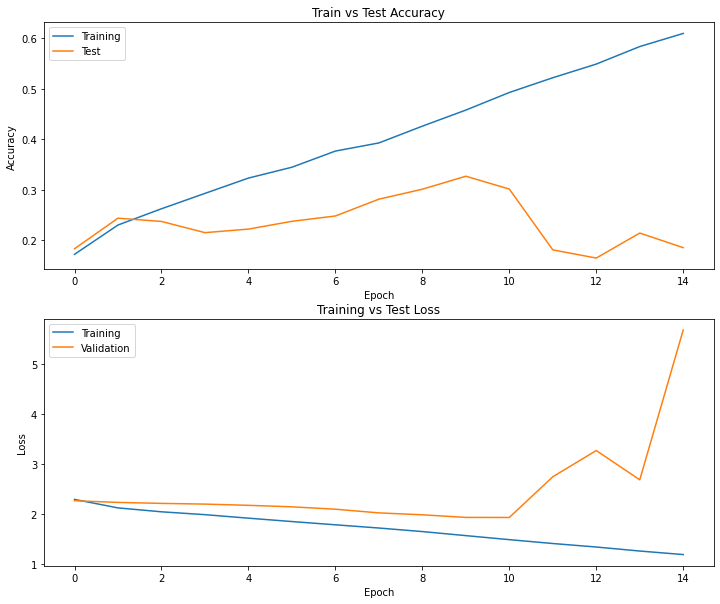

In [112]:
plot_learning_curves(history_cnn_stem)

              precision    recall  f1-score   support

           0       0.76      0.23      0.36       810
           1       0.89      0.53      0.66       960
           2       0.39      0.06      0.11       810
           3       0.00      0.00      0.00       660
           4       0.45      0.01      0.01       660
           5       0.34      0.05      0.09      1110
           6       0.82      0.02      0.04       495
           7       0.20      0.97      0.33      1410
           8       0.00      0.00      0.00       510
           9       0.00      0.00      0.00       510

    accuracy                           0.28      7935
   macro avg       0.39      0.19      0.16      7935
weighted avg       0.40      0.28      0.20      7935



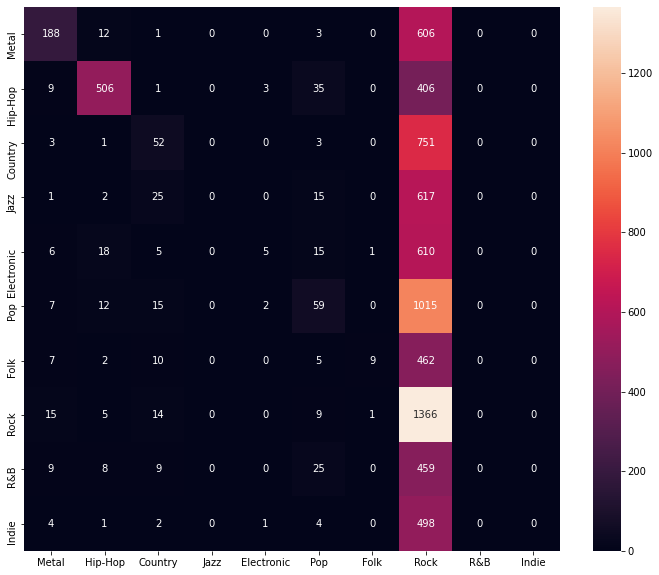

In [116]:
model_cnn_stem = load_model(MODEL_CHECKPOINT_PATH + 'Model cnn')
predictions = np.argmax(model_cnn_stem.predict(X_test_tokenized_stem), axis = 1)
mc_stemming.plot_confusion_matrix(mc_stemming.y_test, predictions)

In [117]:
print("\nTest accuracy: {}".format(model_cnn_stem.evaluate(X_test_tokenized_stem, mc.y_test)[1]))

248/248 [==============================] - 4s 15ms/step - loss: 1.9867 - accuracy: 0.2754

Test accuracy: 0.2753623127937317


In this case also, we overfit on the training data. (Except the hiphop genre, all of the the other genres were badly missclasified).

##Barplot comparison

In [126]:
lstm_nostopWords, lstm_noStemming = 0.33509, 0.3470
cnn_noStopWords, cnn_noStemming = 0.2883, 0.2753

In [128]:
prep = ["No stop words", "No stop words + stemming"]

acc_dict = {prep[0]: [lstm_nostopWords, cnn_noStopWords], 
     prep[1]: [lstm_noStemming, cnn_noStemming]}
df_acc = pd.DataFrame(acc_dict)

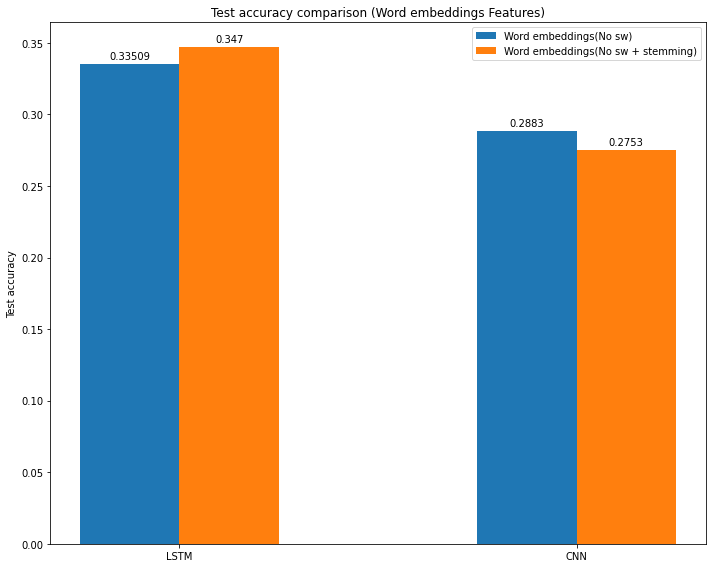

In [133]:
labels = ['LSTM', 'CNN']
sw_scores = list(df_acc["No stop words"])
sm_scores = list(df_acc["No stop words + stemming"])

x = np.arange(len(labels))
width = 0.25 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, sw_scores, width, label='Word embeddings(No sw)')
rects2 = ax.bar(x + width/2, sm_scores, width, label='Word embeddings(No sw + stemming)')

ax.set_ylabel('Test accuracy')
ax.set_title('Test accuracy comparison (Word embeddings Features)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="best")


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

#Conclusion and future work
From all the experiments, the SVM model (with TF-IDF and no stop words + stem) performed the best on the test set. The deep learning based models perfomed poorly (especially lstm and cnn models) in comparison to other models. Also, the training time is very high for this kind of models (since i've also used word embeddings as features).
Except the hip-hop genre, all of the other genres were more or less badly missclasified (this may be because there are genres which use similar lyrics and style, like pop and dance, making it hard to distinguish between the two). Using other preprocessing or feature extraction techniques from pretrained models (like BERT) might be a solution to improve the accuracy on this task.
